### Initial Setup
更新keras_applications和keras

In [ ]:
!pip install --upgrade keras_applications==1.0.6
!pip install --upgrade keras==2.2.4

pandas降级到0.20.3，解决兼容性问题

In [1]:
import pandas as pd
print(pd.__version__)

0.20.3


In [ ]:
!pip uninstall -y pandas
!pip install pandas==0.20.3  # Compatibility

Let's start by importing some packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tqdm import tqdm
from os import listdir, makedirs
from os.path import join

/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ma-u

### Training Parameters

In [3]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 32  # Number of images used in each iteration
    EPOCHS = 3  # Number of passes through entire dataset
    print("Using GPU for training!")
    
# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 4
    EPOCHS = 1
    print("Using CPU for training")

Using GPU for training!


从OBS上下载数据

In [4]:
from modelarts.session import Session
session = Session()
bucket_path="canis-dataset/dog-breed-identification.zip"

In [ ]:
if not os.path.exists('./data'):
    session.download_data(
    bucket_path= bucket_path,
    path="./dog-breed-identification.zip")

下载并解压缩

In [ ]:
!unzip ./dog-breed-identification.zip

In [ ]:
!rm -f ./dog-breed-identification.zip

In [ ]:
!unzip -n -qq "train.zip"
!unzip -n -qq "test.zip"

In [ ]:
!rm -f ./train.zip
!rm -f ./test.zip

### Data

这里我们为了演示效果，NUM_CLASSES只取了图片数量最多的10个dog breeds，当然你可以任意选取NUM_CLASSES。

In [5]:
# Keep only the first 10 classes
NUM_CLASSES = 10 

data_dir = '.' # ADD path/to/dataset
labels = pd.read_csv(join(data_dir, 'labels.csv')) # EDIT WITH YOUR LABELS FILE NAME
print("Total number of images in the dataset: {}".format(len(listdir(join(data_dir, 'train'))))) 

print("Top {} labels (sorted by number of samples)".format(NUM_CLASSES))
(labels
 .groupby("breed")
 .count()
 .sort_values("id", ascending=False)
 .head(NUM_CLASSES)
)

Total number of images in the dataset: 10222
Top 10 labels (sorted by number of samples)


,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


### Data augmentation

从数据集上来看，我们每一类只有~100张图片,所以用数据增广的方法来增加训练数据集

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob

temp_val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True)

from PIL import Image
sample_img = Image.open(glob('./train/*.jpg')[0])
sample_img = np.expand_dims(sample_img, axis=0)

i = 0
plt.figure(figsize=(20, 10))
for batch in temp_val_datagen.flow(sample_img):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(np.squeeze(batch))
    
    i += 1
    if i >= 8:
        break

plt.show()

Using TensorFlow backend.


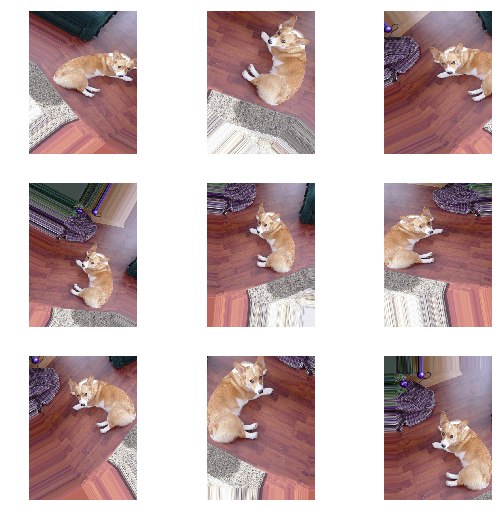

In [6]:
from support import data_augmentation_example
input_path = 'train/549144e54ff57b7387c91e893d7d35b4.jpg' # An example image from the dataset
count = 9 # Number of samples to show

data_augmentation_example(input_path, count)

### Train - Val Split

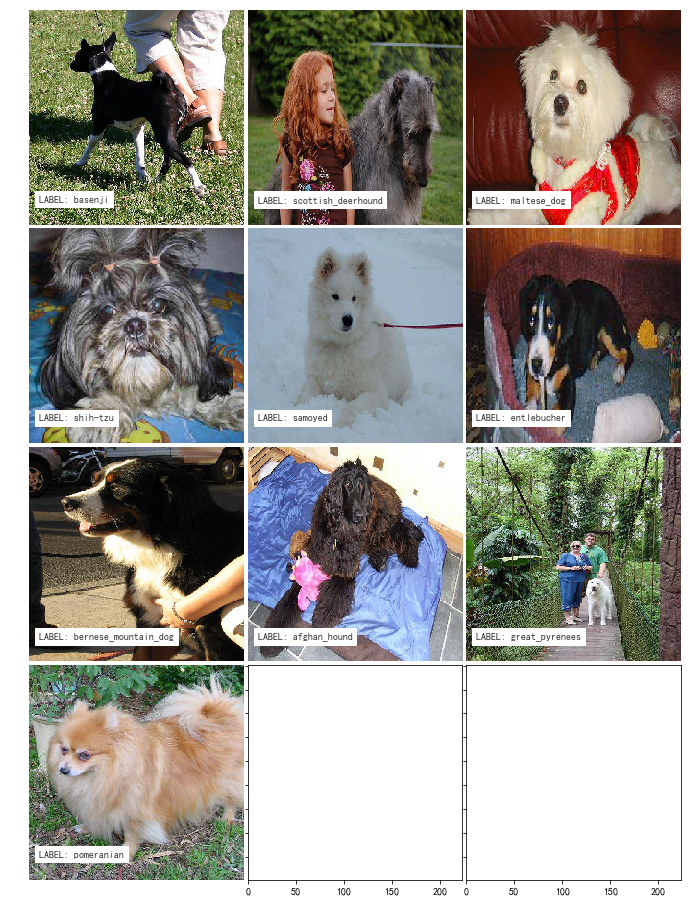

In [7]:
from support import split_train_val

# Make sure to have the same split
SEED = 2019

(train_idx, valid_idx, ytr, yv, labels, selected_breed_list) = split_train_val(labels, NUM_CLASSES, seed=SEED)

from keras.preprocessing import image
from support import show_images

show_images(NUM_CLASSES, labels, data_dir)

### Data Preprocessing


In [8]:
# DATA LOADER
from keras.applications import xception
from support import read_img

INPUT_SIZE = 299 # width/height of image in pixels (as expected by Xception model)

x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, data_dir, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('\nTotal Images shape: {}'.format(x_train.shape))

Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print('Train (images, H, W, C):', Xtr.shape,
      '\nVal (images, H, W, C):', Xv.shape, 
      '\n\nTrain samples (images, labels)', ytr.shape,
      '\nValidation samples (images, labels)', yv.shape)

1141it [00:04, 270.64it/s]



Total Images shape: (1141, 299, 299, 3)
Train (images, H, W, C): (916, 299, 299, 3) 
Val (images, H, W, C): (225, 299, 299, 3) 

Train samples (images, labels) (916, 10) 
Validation samples (images, labels) (225, 10)


In [9]:
# Data Loader
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator()

### Model definition

这里我们在pre-trained Xception模型上应用迁移学习(Transfer Learning)。

In [10]:
### MODEL - BOTTLENECK FEATURES - OPTMIZER

from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input

# Download and create the pre-trained Xception model for transfer learning
base_model = xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [11]:
# TRAINING
hist = model.fit_generator(train_datagen.flow(Xtr, ytr, batch_size=BATCH_SIZE),
                           steps_per_epoch=train_idx.sum() // BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE),
                           validation_steps=valid_idx.sum() // BATCH_SIZE,
                           verbose=1)

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/3
28/28 [==============================] - 17s 590ms/step - loss: 0.5182 - acc: 0.8292 - val_loss: 0.0806 - val_acc: 0.9688
Epoch 2/3
28/28 [==============================] - 14s 497ms/step - loss: 0.2494 - acc: 0.9205 - val_loss: 0.0923 - val_acc: 0.9689
Epoch 3/3
28/28 [==============================] - 15s 518ms/step - loss: 0.2899 - acc: 0.9092 - val_loss: 0.0439 - val_acc: 0.9845


### Evaluate on validation set

In [22]:
# EVAL
test_gen = test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE, shuffle=False)
probabilities = model.predict_generator(test_gen, len(Xv) / BATCH_SIZE)

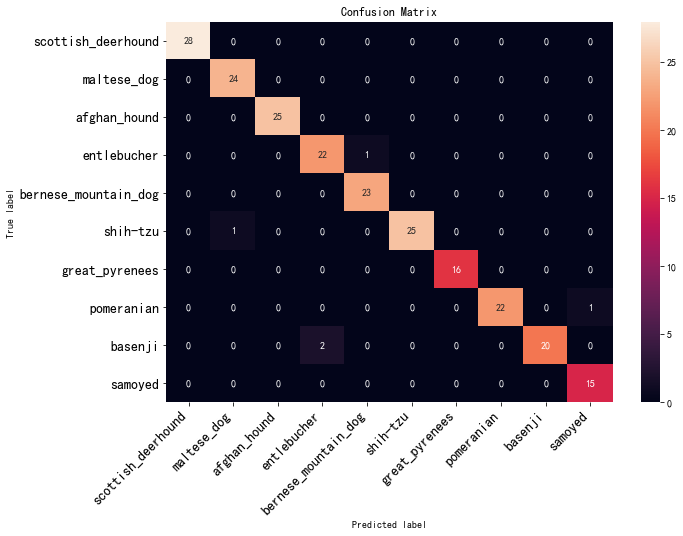

In [23]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
from support import print_confusion_matrix

cnf_matrix = confusion_matrix(np.argmax(yv, axis=1), np.argmax(probabilities,axis=1))
_ = print_confusion_matrix(cnf_matrix, selected_breed_list)

In [24]:
# Print Precision Recall F1-Score Report
from sklearn.metrics import classification_report

report = classification_report(np.argmax(probabilities,axis=1), np.argmax(yv, axis=1), target_names=selected_breed_list)
print(report)

                      precision    recall  f1-score   support

  scottish_deerhound       1.00      1.00      1.00        28
         maltese_dog       1.00      0.96      0.98        25
        afghan_hound       1.00      1.00      1.00        25
         entlebucher       0.96      0.92      0.94        24
bernese_mountain_dog       1.00      0.96      0.98        24
            shih-tzu       0.96      1.00      0.98        25
      great_pyrenees       1.00      1.00      1.00        16
          pomeranian       0.96      1.00      0.98        22
             basenji       0.91      1.00      0.95        20
             samoyed       1.00      0.94      0.97        16

         avg / total       0.98      0.98      0.98       225



##### 测试图片地址

Bernese: https://cdn.pixabay.com/photo/2016/02/06/19/18/dog-1183475_960_720.jpg

Shih-tzu: https://cdn.pixabay.com/photo/2016/10/08/11/21/shih-tzu-puppy-1723492_960_720.jpg

Samoyed: https://cdn.pixabay.com/photo/2017/06/14/00/59/samoyed-2400687_960_720.jpg

In [27]:
# Testing on url images
from support import prediction_from_url
from ipywidgets import interact_manual
from ipywidgets import widgets

def get_prediction(URL):
    prediction_from_url(URL, model, selected_breed_list)

interact_manual(get_prediction, URL=widgets.Text(placeholder='Insert URL with a dog pic'));

interactive(children=(Text(value='', description='URL', placeholder='Insert URL with a dog pic'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

### 保存模型

In [29]:
!mkdir models
# Saving Model Weight
model.save_weights('models/tl_xception_weights.h5')